## Risk Alive ML/NL Case Study: Text Classification using DBpedia14 Dataset


## Objective

This case study is comprimised of 2 steps:

1. We are going to use python to deploy a web service that provides a text classification service using ML and NLP on provided training and testing data. This simple web service will only require the user to provide a text. It is preferred that we allow the user to upload a CSV file that contains the text, but we can also choose to ask the user to type the text in a text box, the web service will then provide the user with the most related topic to the entered text among the 14 labels.

2. Instead of useing provided training and testing data, which are selected rows from **DBpedia14** dataset, in this step we are going to use the full dataset. Considering that we now have extra amount of data, we should update our model, and comment on the model performance after integrating the new dataset. We should deploy the model, and update our web service so it uses the most recent version of the model.

## DBpedia Dataset

### Dataset Summary:
The DBpedia ontology classification dataset is constructed by picking 14 non-overlapping classes from DBpedia 2014. They are listed in classes.txt. From each of thse 14 ontology classes, we randomly choose 40,000 training samples and 5,000 testing samples. Therefore, the total size of the training dataset is 560,000 and testing dataset 70,000. There are 3 columns in the dataset (same for train and test splits), corresponding to class index (1 to 14), title and content. The title and content are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). There are no new lines in title or content.

- Download [Training set](https://drive.google.com/file/d/1TDd7B33nyOwa9grlerAjXCs2Jj1wEb7t/view?usp=sharing)
- Download [Testing set](https://drive.google.com/file/d/1Bs1Nu_wNhoJaNZY8Rkzvj5V7A8h37nDk/view?usp=sharing)
- About [DBpedia14](https://huggingface.co/datasets/viewer/?dataset=dbpedia_14)



## Importing requiered libraries and modules

We are going to use a few libraries and modules in this project. So, the very first step is to import them:

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import metrics
import joblib

If any of the libraries is missing in your Python, you can easily add it using `pip` command.

- in the command line: 
    - `pip install <library_name>` 
- or you can uncomment the following code cell and then run it to install pandas for example.

In [2]:
#!pip3 install pandas

# Step 1:

## Loading provided datasets:

I have download the provided datasets in advance and placed them in `data` folder in the main projects foder. Now I use the following commands to read them and put them into pandas dataframes:

In [3]:
training_df = pd.read_csv(os.getcwd() + r'\data\train.csv')
testing_df = pd.read_csv(os.getcwd() + r'\data\test.csv')

Now that we have our training and testing sets in a dataframe, let's see what are their shapes.

In [4]:
training_df.shape, testing_df.shape

((1000, 3), (70000, 3))

We have 1000 rows and 3 features in our training set, and 70,000 rows and 3 features in our testing set. We always use the most part of the full dataset for training and a small part for testing. But in this case the training set has way less rows than the testing set. 

Anyways, let's take a look at first 20 rows of training data:

In [5]:
training_df.head(20)

,label,title,content
0,7,Joppenbergh Mountain,Joppenbergh Mountain is a nearly 500-foot (15...
1,11,Open Heart Surgery,Open Heart Surgery was released on August 8 2...
2,6,Church of SS Peter & Paul Aston,The Parish Church of St Peter and St Paul (gr...
3,12,Cheran Chozhan Pandian,Cheran Chozhan Pandian is a 1998 Tamil comedy...
4,12,A Shot in the Dark (1933 film),A Shot in the Dark is a 1933 British mystery ...
5,13,Worthy Is the Lamb,Worthy is the Lamb is an outdoor drama which ...
6,4,Hisakazu Tanaka,Hisakazu Tanaka (田中 久一 Tanaka Hisakazu 16 Mar...
7,7,Pârâul Ştreaurilor,The Pârâul Ștreaurilor is a tributary of the ...
8,5,HMAS Snipe,HMAS Snipe (M1102) (formerly HMS Alcaston) wa...
9,0,Anjali Mukerjee's Health Total,Health Total cofounded by Dr. Anjali Mukerjee...


Since we don't want duplicate instances to affect our model, let's check and see if we have duplicate rows in our training set:

In [6]:
training_df.drop_duplicates()

,label,title,content
0,7,Joppenbergh Mountain,Joppenbergh Mountain is a nearly 500-foot (15...
1,11,Open Heart Surgery,Open Heart Surgery was released on August 8 2...
2,6,Church of SS Peter & Paul Aston,The Parish Church of St Peter and St Paul (gr...
3,12,Cheran Chozhan Pandian,Cheran Chozhan Pandian is a 1998 Tamil comedy...
4,12,A Shot in the Dark (1933 film),A Shot in the Dark is a 1933 British mystery ...
...,...,...,...
995,9,Pacific horned frog,The Pacific Horned Frog (Ceratophrys stolzman...
996,6,Second Presbyterian Church (Birmingham Alabama),Second Presbyterian Church is a historic chur...
997,13,The Bravo,The Bravo is a novel by James Fenimore Cooper...
998,0,Artizone,Artizone is an online food delivery service c...


Having the same rows and columns after running `drop_duplicates()` will show that we didn't have any duplicate rows.

In [7]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    1000 non-null   int64 
 1   title    1000 non-null   object
 2   content  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


`info()` shows that our `label` feature is of integer type, and both `title` and `content` features are string type. Besides, since all the features have 1000 Non-Null values, we conclude that we don't have missing values in our training set.

Let's see how many samples we have for each label in our training set:

In [8]:
training_df.label.value_counts().sort_index()

0     75
1     71
2     64
3     74
4     65
5     67
6     88
7     64
8     79
9     77
10    66
11    73
12    63
13    74
Name: label, dtype: int64

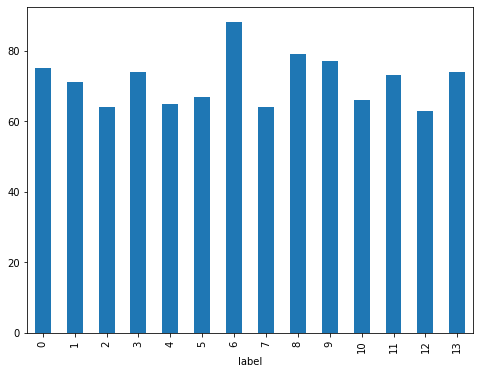

In [9]:
fig = plt.figure(figsize=(8,6))
training_df.groupby('label').content.count().plot.bar(ylim=0)
plt.show()

As above figure illustrates, we have an imbalanced dataset. However, since the number of samples for all the labels are close enough (around 65-80) it can be left as it is. Anyways, We are going to check the confusion matrix of our models to have a better understanding of how our models perform on the training set.

## Training and Testing features and target values

Considering the objective of this case study and looking at the features, it's obviouse that our `label` feature is our target value (y). Moreover, `title` values seem to be redundant because apparently titles are the exact first words of the `content` values. Therefore, We are going to use `content` feature to train the model and predict the values of `label` for each content (X).

In [10]:
training_X = training_df.content
training_y = training_df.label
training_X, training_y

(0       Joppenbergh Mountain is a nearly 500-foot (15...
 1       Open Heart Surgery was released on August 8 2...
 2       The Parish Church of St Peter and St Paul (gr...
 3       Cheran Chozhan Pandian is a 1998 Tamil comedy...
 4       A Shot in the Dark is a 1933 British mystery ...
                              ...                        
 995     The Pacific Horned Frog (Ceratophrys stolzman...
 996     Second Presbyterian Church is a historic chur...
 997     The Bravo is a novel by James Fenimore Cooper...
 998     Artizone is an online food delivery service c...
 999     Asura compsodes is a moth of the Arctiidae fa...
 Name: content, Length: 1000, dtype: object,
 0       7
 1      11
 2       6
 3      12
 4      12
        ..
 995     9
 996     6
 997    13
 998     0
 999     9
 Name: label, Length: 1000, dtype: int64)

In [11]:
testing_X = testing_df.content
testing_y = testing_df.label
testing_X, testing_y

(0         TY KU /taɪkuː/ is an American alcoholic bever...
 1         OddLot Entertainment founded in 2001 by longt...
 2         Henkel AG & Company KGaA operates worldwide w...
 3         The GOAT Store (Games Of All Type Store) LLC ...
 4         RagWing Aircraft Designs (also called the Rag...
                                ...                        
 69995     Energy Victory: Winning the War on Terror by ...
 69996     Bestiario is a book of 8 short stories writte...
 69997     Wuthering Heights is a novel by Emily Brontë ...
 69998     L'Indépendant is a newspaper published in Lux...
 69999     The Prophecy is the fifth novel by New York T...
 Name: content, Length: 70000, dtype: object,
 0         0
 1         0
 2         0
 3         0
 4         0
          ..
 69995    13
 69996    13
 69997    13
 69998    13
 69999    13
 Name: label, Length: 70000, dtype: int64)

## Extracting features from text

In order to perform machine learning on text documents, we first need to turn the text into numerical feature vectors.  
One way to do so is to use a **Bag of Words** representation. Bag of words is representation of text that describes the occurrence of words within a document. It does two things:

1. Uses all the documents in the training set and builds a dictionary from all the words to integer indices
2. Converts each document to a fixed length (equal to the length of dictionary) vector, where each index referes to it's corresponding word in the dictionary, and each value referes to the number of occurrences of that word in that document

Since Bag of Words uses all the documnets in the training set to create the vocabulary, and then uses that to convert each document into vectors, the vectors would be so sparse. In order to save a lot of memory, vectors are usually saved as **spicy.sparse** matrices, where only non-zero parts of the feature vector is saved in the memory.

Now we are going to use `CountVectorizer` on the training set as a Bag of Words. Text preprocessing, tokenizing and filtering of stopwords are all included in it.

In [12]:
count_vectorizer = CountVectorizer()
training_X_count_vectors = count_vectorizer.fit_transform(training_X)
training_X_count_vectors

<1000x10145 sparse matrix of type '<class 'numpy.int64'>'
	with 34850 stored elements in Compressed Sparse Row format>

As can be seen, we have one sparse matrix of size 1000x10145, which means our bag of words has 10145 feature names. It also indicates the number of non-zero elements stored in the sparse matrix (34,850).

In [13]:
len(count_vectorizer.get_feature_names())

10145

Let's take a look at the first vector (in sparse matrix format):

In [14]:
print(training_X_count_vectors[0])

  (0, 4823)	1
  (0, 6035)	3
  (0, 4681)	2
  (0, 6175)	1
  (0, 455)	1
  (0, 3639)	1
  (0, 77)	1
  (0, 4536)	4
  (0, 7724)	3
  (0, 9505)	1
  (0, 4125)	1
  (0, 8945)	4
  (0, 9094)	1
  (0, 6401)	3
  (0, 9286)	1
  (0, 2419)	1
  (0, 6217)	1
  (0, 9856)	1
  (0, 2263)	1
  (0, 1820)	1
  (0, 1328)	1
  (0, 6586)	1
  (0, 1725)	1
  (0, 3896)	1
  (0, 2741)	1
  (0, 5704)	1
  (0, 4700)	1
  (0, 9607)	2
  (0, 6126)	1
  (0, 683)	1
  (0, 3689)	1
  (0, 4724)	1
  (0, 7783)	1
  (0, 853)	1
  (0, 5903)	1
  (0, 8996)	1
  (0, 5178)	1
  (0, 323)	1
  (0, 1915)	1
  (0, 3644)	1
  (0, 2932)	1
  (0, 8944)	1
  (0, 9367)	1
  (0, 5603)	1
  (0, 6155)	1
  (0, 1902)	1


Let's take a look at all the words we have in our Bag of Words:

In [15]:
count_vectorizer.get_feature_names()

['000234c',
 '003',
 '004',
 '01',
 '011',
 '03',
 '056',
 '06',
 '09',
 '10',
 '100',
 '1000',
 '1000m',
 '1012',
 '102',
 '1021',
 '1041000',
 '106',
 '1063',
 '108',
 '1092',
 '1093',
 '10th',
 '11',
 '110',
 '111',
 '1115',
 '1119',
 '112',
 '113',
 '1139',
 '11416',
 '1154',
 '1181',
 '119',
 '1195',
 '11th',
 '12',
 '1200',
 '1201',
 '1206',
 '1214',
 '123',
 '124',
 '1241',
 '1256',
 '127',
 '12th',
 '12½',
 '13',
 '130',
 '1300',
 '13000',
 '131',
 '1324',
 '13312',
 '135',
 '1355',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '1400',
 '1409',
 '1433',
 '1437',
 '144',
 '1451',
 '149',
 '14th',
 '15',
 '150',
 '1500',
 '15000',
 '1508',
 '152',
 '1537',
 '155',
 '1553',
 '1554',
 '157078',
 '1586',
 '1587',
 '15th',
 '16',
 '160',
 '1611',
 '162',
 '1625',
 '163',
 '164',
 '165',
 '166',
 '1661',
 '167',
 '1692',
 '1699',
 '17',
 '1705',
 '1706',
 '171',
 '17132',
 '1715',
 '173',
 '1730s',
 '1735',
 '1737',
 '1739',
 '1742',
 '175',
 '1753',
 '17531',
 '1756',
 '1760',
 '17

## TF-IDF

Occurrence counting is a good start but there is a downside to it. Longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. To avoid these potential discrepancies we could divide the number of occurrences of each word in a document by the total number of words in the document. These new features are called Term Frequencies (TF).  
Another refinement on top of TF is to downscale weights for words that occur in many documents in the corpus (a large and unstructured set of texts) and are therefore less informative than those that occur only in a smaller portion of the corpus.  
These two techniques are called **TF-IDF**, which means **Term Frequency** times **Inverse Document Frequency**.  
TF-IDF is a common term weighting scheme in information retrieval, that has also found good use in document classification.

Therefore, after creating count vectors using `CountVectorizer`, we transform them to TF-IDF representation using `TFidfTransformer`.

In [16]:
tfidf_transformer = TfidfTransformer()
training_X_tfidf_vectors = tfidf_transformer.fit_transform(training_X_count_vectors)
training_X_tfidf_vectors.shape

(1000, 10145)

Note that we passed the vectors from the `CountVectorizer` to `tfidf_transformer` to apply TF-IDF on them.

Let's take a look at the first TF-IDF vector (in sparse matrix format):

In [17]:
print(training_X_tfidf_vectors[0])

  (0, 9856)	0.0942995118353981
  (0, 9607)	0.07955557167349132
  (0, 9505)	0.07528927900839194
  (0, 9367)	0.11136324958187363
  (0, 9286)	0.1583187764605536
  (0, 9094)	0.10473085762771475
  (0, 8996)	0.13083170795623364
  (0, 8945)	0.09837622966924833
  (0, 8944)	0.07479619855835666
  (0, 7783)	0.1583187764605536
  (0, 7724)	0.4749563293816607
  (0, 6586)	0.1583187764605536
  (0, 6401)	0.08508931455594339
  (0, 6217)	0.0765727534410944
  (0, 6175)	0.13421395216599696
  (0, 6155)	0.12300584714746993
  (0, 6126)	0.10779739629542204
  (0, 6035)	0.3171185421374632
  (0, 5903)	0.1583187764605536
  (0, 5704)	0.14311032560850567
  (0, 5603)	0.1583187764605536
  (0, 5178)	0.11724927172828671
  (0, 4823)	0.1583187764605536
  (0, 4724)	0.14942240301804485
  (0, 4700)	0.04481013284659725
  (0, 4681)	0.050290239992513454
  (0, 4536)	0.10898593650180571
  (0, 4125)	0.14942240301804485
  (0, 3896)	0.14942240301804485
  (0, 3689)	0.12300584714746993
  (0, 3644)	0.05392513884027083
  (0, 3639)	0.138

Having our training set converted to TF-IDF feature vectors, we can now train a model.

## Training a Classifier

Now that we have our features, we can train a classifier to try to predict the labels. Let’s start with a naïve Bayes classifier, which provides a nice baseline for this task. Scikit-learn includes several variants of this classifier. Based on their documentation the one most suitable for word counts is the multinomial variant:

In [18]:
MultinomialNB_Model = MultinomialNB()
MultinomialNB_Model.fit(training_X_tfidf_vectors, training_y)

MultinomialNB()

Now that we trained a model based on training set, we could try to predict the label of a new document using our model. However, we need to extract the TF-IDF feature vector of the new document using almost the same feature extracting steps as before. The only difference is that we call `transform()` instead of `fit_transform()` on transformers (`CountVectorizer` and `TFidfTransformer`), since they have already been fit on the training set:

In [19]:
new_document = ['The Greater Hairy-Winged Bat (Harpiocephalus mordax) is a species of vesper bat in the \
                Vespertilionidae family.It can be found in the following countries: Laos Malaysia Myanmar and Thailand.'] 
                #content copied from the test set, and actual label is 9.

In [20]:
new_document_count_vector = count_vectorizer.transform(new_document)
new_document_count_vector

<1x10145 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [21]:
new_document_tfidf_vector = tfidf_transformer.transform(new_document_count_vector)
new_document_tfidf_vector

<1x10145 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [22]:
predicted = MultinomialNB_Model.predict(new_document_tfidf_vector)
predicted

array([9], dtype=int64)

## Building a Pipeline

Instead of all the steps we took from `vectorizer` to `transformer` to `classifier`, we could use a `Pipeline` class that behaves like a compound classifier. A pipeline sequentially applies a list of transforms and a final estimator. Intermediate steps of the pipeline must be `transforms`, that is, they must implement `fit` and `transform` methods. The final estimator only needs to implement `fit`. Each step in a pipeline is a tuple. The first element is the name we give to a step as a string, and the second element is the transformer/classifier object.

In [23]:
MultinomialNB_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                   ('tfidf_transformer', TfidfTransformer()),
                                   ('MultinomialNB', MultinomialNB()),
])

Using our pipeline, all we need to do to train our model is to `fit` our pipeline with our training data.

In [24]:
MultinomialNB_pipeline.fit(training_X, training_y)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('MultinomialNB', MultinomialNB())])

now we can predict a new document using our pipeline:

In [25]:
MultinomialNB_pipeline.predict(new_document)

array([9], dtype=int64)

## Evaluating on Test set

Let's evaluate our model's performance on test set. First we need to predict the labels for `testing_X`, then we can create a confusion matrix using actual and predicted labels:

In [26]:
predicted_y = MultinomialNB_pipeline.predict(testing_X)

In [18]:
def plot_the_confusion_matrix(actual, predicted):
    conf_mat = confusion_matrix(actual, predicted)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Greens", xticklabels=range(14), yticklabels=range(14))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

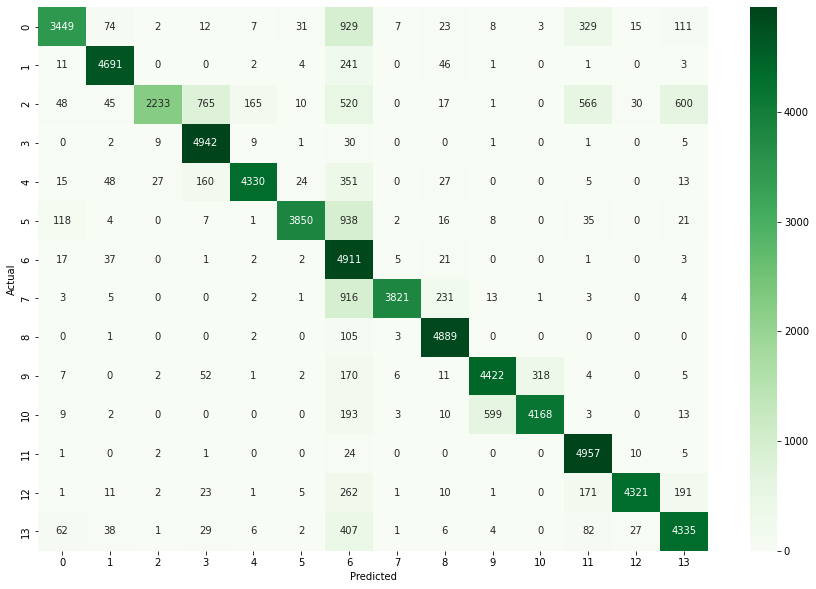

In [28]:
plot_the_confusion_matrix(testing_y, predicted_y)

As heatmap illustrates, most of the predicted labels match their actual labels. However, it's clear that we have lots of FN cases for label 2, and significant amount of FP cases for label 6. 

We can also take a look at `precision`, `recall`, and `f1-score` of the confusion matrix using `classification_report`:
`support` is the number of samples for each label in the testing set.

In [19]:
def print_the_classification_report(actual, predicted):
    print(metrics.classification_report(actual, predicted))

In [30]:
print_the_classification_report(testing_y, predicted_y)

              precision    recall  f1-score   support

           0       0.92      0.69      0.79      5000
           1       0.95      0.94      0.94      5000
           2       0.98      0.45      0.61      5000
           3       0.82      0.99      0.90      5000
           4       0.96      0.87      0.91      5000
           5       0.98      0.77      0.86      5000
           6       0.49      0.98      0.65      5000
           7       0.99      0.76      0.86      5000
           8       0.92      0.98      0.95      5000
           9       0.87      0.88      0.88      5000
          10       0.93      0.83      0.88      5000
          11       0.80      0.99      0.89      5000
          12       0.98      0.86      0.92      5000
          13       0.82      0.87      0.84      5000

    accuracy                           0.85     70000
   macro avg       0.89      0.85      0.85     70000
weighted avg       0.89      0.85      0.85     70000



As can be seen, the accuracy of our model is **85.0%** which is the mean of f1-scores of all the labels.  
Basically, considering precision and recall for each label, if we have:

- **High precision** and **high recall**: The class is perfectly handled by the model
- **High precision** and **low recall**:  The model can’t detect the class well but is highly trustable when it does
- **Low precision** and **high recall**:  The class is well detected but the model also include points of other classes in it
- **Low precision** and **low recall**:   The class is poorly handled by the model

## Fine Tunning Model's Hyperparameters

So far we have used the default forms of our transformers and classifier. However, they all have many hyperparameter that we can set in order to increase the performance of our model.  
For example, running the next cell will show us `TfidfTransformer` documents including all the parameters we can set.  

In [31]:
TfidfTransformer?

To find the best combination of hyperparameters for our model, one approach would be to tweak one hyperparameter at a time, fit the model, and keep track of that run's output, and then do the same thing with a new value.  
Instead of searching for best compination of parameters manually, we could use `GridSearchCV`. `GridSearchCV` applies an exhaustive search over specified parameter values for an estimator. It also allows us to set the K-Fold **Cross Validation** value. It automatically keeps track of all the runs, and after the search is done we can get the `best_estimator_` and `best_params_` values to see which hyperparameters led to the best results, and also get the `best_score_` itself. 


For using `GridSearchCV` first we need to provide it a list of parameters. Since we are using a pipeline which has few steps, we need to prepare a list of parameters for each step, and put them all in a dictionary. First let's take a look at our pipeline and its steps:

In [32]:
MultinomialNB_pipeline

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('MultinomialNB', MultinomialNB())])

Now we set our parameters dictionary as follows:

In [33]:
parameters = {'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
              'count_vectorizer__min_df': [i for i in range(1, 6)],
              'tfidf_transformer__use_idf': [True, False],  
              'tfidf_transformer__sublinear_tf': [True, False],
              'MultinomialNB__alpha': [0.01, 0.001]
             }

Note how we add the step's name, followed by double underscores prefix to the parameter's name to specify which step it belongs to. For example, `tfidf_transformer__use_idf` indicates that `use_idf` parameter belongs to the second step of our pipeline which is entitled as `tfidf_transformer`.

Obviously, such an exhaustive search can be expensive. If we have multiple CPU cores at our disposal, we can tell the grid searcher to try these eight parameter combinations in parallel with the n_jobs parameter. If we give this parameter a value of -1, grid search will detect how many cores are installed and use them all.
We pass our pipeline and parameters dictionary to the `GridSearchCV`, set the `cv` and `n_jobs` values, and then fit the grid search:

In [34]:
grid_search = GridSearchCV(MultinomialNB_pipeline, parameters, cv=10, n_jobs=-1)

In [35]:
grid_search.fit(training_X, training_y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_transformer',
                                        TfidfTransformer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'MultinomialNB__alpha': [0.01, 0.001],
                         'count_vectorizer__min_df': [1, 2, 3, 4, 5],
                         'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidf_transformer__sublinear_tf': [True, False],
                         'tfidf_transformer__use_idf': [True, False]})

After the grid seach is done fitting our training data, we can get the best estimator using `best_estimator_` attribute:

In [36]:
grid_search.best_estimator_

Pipeline(steps=[('count_vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf_transformer', TfidfTransformer(use_idf=False)),
                ('MultinomialNB', MultinomialNB(alpha=0.01))])

Getting the best parameters using `best_params_` attribute:

In [37]:
grid_search.best_params_

{'MultinomialNB__alpha': 0.01,
 'count_vectorizer__min_df': 1,
 'count_vectorizer__ngram_range': (1, 2),
 'tfidf_transformer__sublinear_tf': False,
 'tfidf_transformer__use_idf': False}

Note that there are few parameters which are listed in `best_params_` and can't be found in the `best_estimator_` parameters. This is because their best value found by grid search is actually their default values, so they can be removed.
For example, we don't need to set the `sublinear_tf` parameter to `False`, because `False` is the default value for `sublinear_tf` parameter in `TfidfTransformer()`.

We can also get the best score using `best_score_` attribute:

In [38]:
grid_search.best_score_

0.915

Details about each run can be obtained like this:

In [39]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)

In [40]:
grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_MultinomialNB__alpha,param_count_vectorizer__min_df,param_count_vectorizer__ngram_range,param_tfidf_transformer__sublinear_tf,param_tfidf_transformer__use_idf,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.162960,0.018682,0.012769,0.005633,0.01,1,"(1, 1)",True,True,"{'MultinomialNB__alpha': 0.01, 'count_vectoriz...",...,0.86,0.88,0.91,0.83,0.89,0.89,0.88,0.883,0.022825,51
1,0.125096,0.005912,0.010281,0.005152,0.01,1,"(1, 1)",True,False,"{'MultinomialNB__alpha': 0.01, 'count_vectoriz...",...,0.91,0.89,0.96,0.85,0.89,0.89,0.89,0.896,0.026153,28
2,0.136318,0.012184,0.015729,0.005698,0.01,1,"(1, 1)",False,True,"{'MultinomialNB__alpha': 0.01, 'count_vectoriz...",...,0.87,0.88,0.92,0.82,0.90,0.90,0.89,0.887,0.025710,46
3,0.153928,0.028618,0.012200,0.001600,0.01,1,"(1, 1)",False,False,"{'MultinomialNB__alpha': 0.01, 'count_vectoriz...",...,0.94,0.89,0.96,0.86,0.91,0.90,0.88,0.903,0.027221,14
4,0.372447,0.018375,0.023115,0.005351,0.01,1,"(1, 2)",True,True,"{'MultinomialNB__alpha': 0.01, 'count_vectoriz...",...,0.90,0.91,0.95,0.87,0.90,0.89,0.89,0.909,0.022561,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.159375,0.011692,0.017187,0.004688,0.001,5,"(1, 1)",False,False,"{'MultinomialNB__alpha': 0.001, 'count_vectori...",...,0.90,0.89,0.94,0.82,0.89,0.88,0.88,0.876,0.034409,63
76,0.348439,0.017187,0.031249,0.000003,0.001,5,"(1, 2)",True,True,"{'MultinomialNB__alpha': 0.001, 'count_vectori...",...,0.87,0.89,0.91,0.85,0.86,0.89,0.87,0.875,0.021095,67
77,0.356249,0.006250,0.029688,0.004685,0.001,5,"(1, 2)",True,False,"{'MultinomialNB__alpha': 0.001, 'count_vectori...",...,0.90,0.91,0.92,0.86,0.87,0.92,0.88,0.894,0.019596,37
78,0.356250,0.011692,0.031250,0.000005,0.001,5,"(1, 2)",False,True,"{'MultinomialNB__alpha': 0.001, 'count_vectori...",...,0.87,0.90,0.91,0.85,0.86,0.89,0.86,0.876,0.022891,63


Grid search instance behaves like a normal model. Therefore, if it's already been fitted, we can use it to predict and score our testing set. Grid search will automatically use the best estimator for predicting and scoring: 

In [41]:
predicted_y = grid_search.predict(testing_X)

In [42]:
grid_search.score(testing_X, testing_y)

0.908

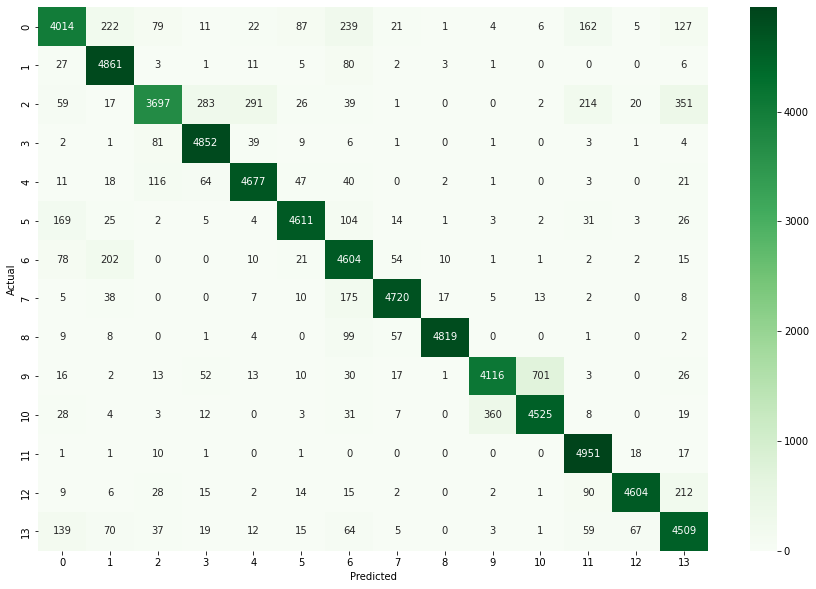

In [43]:
plot_the_confusion_matrix(testing_y, predicted_y)

In [44]:
print_the_classification_report(testing_y, predicted_y)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      5000
           1       0.89      0.97      0.93      5000
           2       0.91      0.74      0.82      5000
           3       0.91      0.97      0.94      5000
           4       0.92      0.94      0.93      5000
           5       0.95      0.92      0.94      5000
           6       0.83      0.92      0.87      5000
           7       0.96      0.94      0.95      5000
           8       0.99      0.96      0.98      5000
           9       0.92      0.82      0.87      5000
          10       0.86      0.91      0.88      5000
          11       0.90      0.99      0.94      5000
          12       0.98      0.92      0.95      5000
          13       0.84      0.90      0.87      5000

    accuracy                           0.91     70000
   macro avg       0.91      0.91      0.91     70000
weighted avg       0.91      0.91      0.91     70000



As can be seen from the confusion matrix and classification report, by fine tunning the hyperparameters we could enhance our model performance on the test set by **6%**, from **85%** to **91%**.

## Finding the best model:

The model we used was a Naive Bayas model, which is a very simple and as the name indicates a Naive one. Now let's try other complex models to see if we could improve the results.
Since the process of building, training and evaluating a model, or better to say a pipeline, would be the same for all new models, we are going to automate the whole process.  
Therefore, We are going to define a function that:

1. Takes training and test sets
2. Applies a Grid search with 10 fold cross validation on different pre-defined pipelines and parameters using the training set to find the best estimators
3. Adds the Grid search results of each run to a list for comparison
4. Compares the `score`'s of each `best_estimator_` on the testing set to find the best-of-all estimator.
5. Saves the best-of-all estimator(pipeline) for deploying.
6. Returns the Grid Search resutls list, in case we want to check or save other estimators.

The advantage of using this function is, whenever we have a new training set, we can pass it to this function and it will automatically finds and saves the best model for us.


Since our case study is a text classifiaction problem, models we are going to try are all classifiers from different categories, and some of them are known for their ability to solve such tasks (SGD, SVM):

1. Multinominal Naive Bayes 
2. Nearest Neighbors Classifier
3. Decision Tree Classifier
4. Random Forest Classifier
5. Stochastic Gradient Descent (SGD) Classifier
6. Support Vector Machines (SVM)

Note that for comparison purposes we add MultinomialNB once again.

In [45]:
def find_and_save_the_best_of_all_estimator(training_X, training_y, testing_X, testing_y):
    
    pipelines_list = []
    parameters_list = []
    grid_search_list = []
    best_score = 0.0
    best_of_all_estimator = None
    #---------------------------------------------------------------------------------------------
    #MoltinomiaNB
    MultinomialNB_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                       ('tfidf_transformer', TfidfTransformer()),
                                       ('MultinomialNB', MultinomialNB())
                                      ])
    
    MultinomialNB_parameters = {'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
                                'tfidf_transformer__use_idf': [True, False], 
                                'tfidf_transformer__sublinear_tf': [True, False],
                                'MultinomialNB__alpha': [0.01, 0.001]
                               }
    pipelines_list.append(MultinomialNB_pipeline)
    parameters_list.append(MultinomialNB_parameters)
    #---------------------------------------------------------------------------------------------
    #KNeighborsClassifier
    KNeighbors_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                    ('tfidf_transformer', TfidfTransformer()),
                                    ('KNeighborsClassifier', KNeighborsClassifier())
                                   ])
    
    KNeighbors_parameters = {'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
                             'tfidf_transformer__use_idf': [True, False], 
                             'tfidf_transformer__sublinear_tf': [True, False],
                             'KNeighborsClassifier__n_neighbors': [i for i in range(3, 10)],
                             'KNeighborsClassifier__n_jobs': [-1]
                            }
    pipelines_list.append(KNeighbors_pipeline)
    parameters_list.append(KNeighbors_parameters)
    #---------------------------------------------------------------------------------------------
    #DecisionTreeClassifier
    DecisionTree_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                      ('tfidf_transformer', TfidfTransformer()),
                                      ('DecisionTree', DecisionTreeClassifier())
                                     ])
    
    DecisionTree_parameters = {'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
                               'tfidf_transformer__use_idf': [True, False],  
                               'tfidf_transformer__sublinear_tf': [True, False],
                               'DecisionTree__splitter': ['best', 'random'],
                               'DecisionTree__max_features': [None, 'auto'],
                               'DecisionTree__random_state': [42]
                              }
    pipelines_list.append(DecisionTree_pipeline)
    parameters_list.append(DecisionTree_parameters)
    #---------------------------------------------------------------------------------------------
    #RandomForestClassifier
    RandomForest_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                      ('tfidf_transformer', TfidfTransformer()),
                                      ('RandomForest', RandomForestClassifier())
                                     ])
    
    RandomForest_parameters = {'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
                               'tfidf_transformer__use_idf': [True, False],  
                               'tfidf_transformer__sublinear_tf': [True, False],
                               'RandomForest__max_features': [None, 'auto'],
                               'RandomForest__random_state': [42],
                               'RandomForest__bootstrap': [True, False],
                               'RandomForest__n_jobs': [-1],
                              }
    pipelines_list.append(RandomForest_pipeline)
    parameters_list.append(RandomForest_parameters)
    #---------------------------------------------------------------------------------------------
    #SGDClassifier
    SGDClassifier_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                       ('tfidf_transformer', TfidfTransformer()),
                                       ('SGDClassifier', SGDClassifier())
                                     ])
    
    SGDClassifier_parameters = {'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
                                'tfidf_transformer__use_idf': [True, False],  
                                'tfidf_transformer__sublinear_tf': [True, False],
                                'SGDClassifier__alpha': [0.01, 0.001, 0.0001],
                                'SGDClassifier__random_state': [42],
                                'SGDClassifier__n_jobs': [-1],
                               }
    pipelines_list.append(SGDClassifier_pipeline)
    parameters_list.append(SGDClassifier_parameters)
    #---------------------------------------------------------------------------------------------
    #SVCClassifier
    SVCClassifier_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                       ('tfidf_transformer', TfidfTransformer()),
                                       ('SVCClassifier', SVC())
                                      ])
    
    SVCClassifier_parameters = {'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
                                'tfidf_transformer__use_idf': [True, False],  
                                'tfidf_transformer__sublinear_tf': [True, False],
                                'SVCClassifier__C': [1, 10, 100],
                                'SVCClassifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                'SVCClassifier__gamma': [10.0, 1.0, 0.1],
                                'SVCClassifier__random_state': [42],
                                'SVCClassifier__probability':[True]
                               }
    pipelines_list.append(SVCClassifier_pipeline)
    parameters_list.append(SVCClassifier_parameters)
    #---------------------------------------------------------------------------------------------

    for pipeline, parameters in zip(pipelines_list, parameters_list):
        grid_search = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)
        grid_search.fit(training_X, training_y)
        grid_search_list.append(grid_search)
        print("Accuracy of {} with best hyperparameters on Training set is {}%, and on Test set is {}%.".format(grid_search.best_estimator_.steps[2][0], round(grid_search.best_score_ * 100, 2), round(grid_search.score(testing_X, testing_y) * 100, 2)))
        print("-"*120)
        
    for gs in grid_search_list:
        gs_score = gs.score(testing_X, testing_y)
        if gs_score > best_score:
            best_score = gs_score
            best_of_all_estimator = gs.best_estimator_
    
    print("Therefore, best of all estimator is:\n {}".format(best_of_all_estimator))
    
    joblib.dump(best_of_all_estimator, os.getcwd() + r"\best_Pipeline.pkl")
    print("Estimator saved in {}\best_Pipeline.pkl".format(os.getcwd()))
    
    return grid_search_list
    

In [46]:
%time grid_search_results_list = find_and_save_the_best_of_all_estimator(training_X, training_y, testing_X, testing_y)

Accuracy of MultinomialNB with best hyperparameters on Training set is 91.5%, and on Test set is 90.8%.
------------------------------------------------------------------------------------------------------------------------
Accuracy of KNeighborsClassifier with best hyperparameters on Training set is 89.0%, and on Test set is 87.38%.
------------------------------------------------------------------------------------------------------------------------
Accuracy of DecisionTree with best hyperparameters on Training set is 76.6%, and on Test set is 74.44%.
------------------------------------------------------------------------------------------------------------------------
Accuracy of RandomForest with best hyperparameters on Training set is 88.7%, and on Test set is 87.2%.
------------------------------------------------------------------------------------------------------------------------
Accuracy of SGDClassifier with best hyperparameters on Training set is 92.8%, and on Test set

Now our best of all trained model is saved, and we can easily load it and use it anywhere, including our web app.

We could also save other models in the list. For example if I want to save SGD estimator (which is at index **5** of the list), I will run the next cell:

In [47]:
#joblib.dump(grid_search_results_list[5], os.getcwd() + r"\SGD_Pipeline.pkl")

And finally let's check our best model's performance before we go to the next step:

In [49]:
predicted_y = grid_search_results_list[5].predict(testing_X)

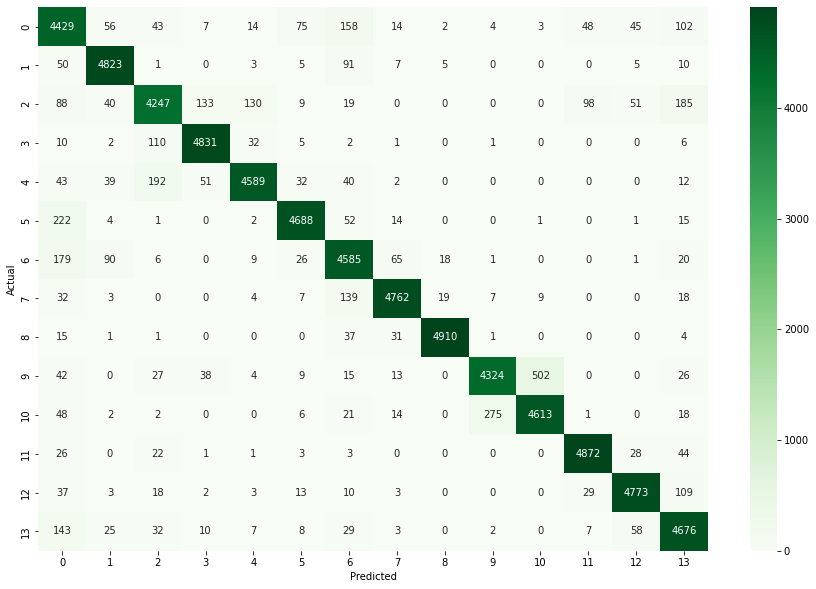

In [50]:
plot_the_confusion_matrix(testing_y, predicted_y)

In [51]:
print_the_classification_report(testing_y, predicted_y)

              precision    recall  f1-score   support

           0       0.83      0.89      0.85      5000
           1       0.95      0.96      0.96      5000
           2       0.90      0.85      0.88      5000
           3       0.95      0.97      0.96      5000
           4       0.96      0.92      0.94      5000
           5       0.96      0.94      0.95      5000
           6       0.88      0.92      0.90      5000
           7       0.97      0.95      0.96      5000
           8       0.99      0.98      0.99      5000
           9       0.94      0.86      0.90      5000
          10       0.90      0.92      0.91      5000
          11       0.96      0.97      0.97      5000
          12       0.96      0.95      0.96      5000
          13       0.89      0.94      0.91      5000

    accuracy                           0.93     70000
   macro avg       0.93      0.93      0.93     70000
weighted avg       0.93      0.93      0.93     70000



## Most relevant features:

Now that we have our best model, we can use its feature names and chi-squared statistic to find most relevant features in our dataset.

The chi-squared statistic is a single number that tells you how much difference exists between your observed counts and the counts you would expect if there were no relationship at all in the population. A low value for chi-square means there is a high correlation between your two sets of data.

Based on **DBpedia14** dataset's documentation, the actual labels of all 14 categories are:

1. Company 
2. EducationalInstitution 
3. Artist
4. Athlete
5. OfficeHolder
6. MeanOfTransportation
7. Building
8. NaturalPlace
9. Village
10. Animal
11. Plant
12. Album
13. Film
14. WrittenWork

In [52]:
model = joblib.load(os.getcwd() + r"\best_Pipeline.pkl")

In [53]:
model

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer(sublinear_tf=True)),
                ('SVCClassifier',
                 SVC(C=10, gamma=1.0, kernel='sigmoid', probability=True,
                     random_state=42))])

In [54]:
def show_most_relevant_features(training_X, count_vectorizer, tfidf_transformer, number_of_features):

    actual_labels = ["Company", "EducationalInstitution", "Artist", "Athlete", "OfficeHolder", "MeanOfTransportation",
                     "Building", "NaturalPlace", "Village", "Animal", "Plant", "Album", "Film", "WrittenWork"]
    
    number_of_most_correlated_features = number_of_features

    count_vectors = count_vectorizer.fit_transform(training_X)
    tfidf_vectors = tfidf_transformer.fit_transform(count_vectors)

    unigrams_column = []
    bigrams_column = []

    for i in set(training_y):
        chi2_ranks = chi2(tfidf_vectors, training_y == i)
        indices_of_sorted_ranks = np.argsort(chi2_ranks[0])
        feature_names = np.array(count_vectorizer.get_feature_names())[indices_of_sorted_ranks]
        unigrams = [name for name in feature_names if len(name.split(' ')) == 1][-number_of_most_correlated_features:]
        bigrams = [name for name in feature_names if len(name.split(' ')) == 2][-number_of_most_correlated_features:]
        unigrams_column.append(unigrams[::-1])
        bigrams_column.append(bigrams[::-1])

    d = {'Actual Labels': actual_labels, 'Relevant Unigram Features': unigrams_column, 'Relevant Bigram Features': bigrams_column}
    df = pd.DataFrame(data=d)
    return df

In [55]:
show_most_relevant_features(training_X, model.steps[0][1], model.steps[1][1], 5)

,Actual Labels,Relevant Unigram Features,Relevant Bigram Features
0,Company,"[company, products, airline, software, exchange]",[]
1,EducationalInstitution,"[school, students, university, secondary, scho...",[]
2,Artist,"[actress, painter, singer, poet, writer]",[]
3,Athlete,"[footballer, football, played, league, player]",[]
4,OfficeHolder,"[politician, party, minister, representatives,...",[]
5,MeanOfTransportation,"[navy, class, uss, ship, royal]",[]
6,Building,"[historic, church, register, building, places]",[]
7,NaturalPlace,"[river, tributary, mountain, romania, lake]",[]
8,Village,"[village, population, district, census, province]",[]
9,Animal,"[family, moth, found, moths, genus]",[]


As can be seen, our model has done a very good job extracting the most relevant features. For some of the labels such as **Company**, **Village**, **Album**, and **Film** the most related feature is the exact title, and for most of them the extracted features are so related to actual labels.  
Note that in each relevant features list, item located at index 0 is the most relevant.  
Besides, although our best model just uses unigram features, I have left the bigram column to be in the dataframe, in case we want to check the most relevant features for a model that uses bigram features in the future.

## Creating a web app

For creating a web app for our classifier, we are going to use Flask (to host on localhost) and eventually deploy it to Heroku (on the web).
**Flask** is a micro web framework written in Python. It is classified as a microframework because it does not require particular tools or libraries. However, Flask supports extensions that can add application features as if they were implemented in Flask itself.
And **Heroku** is a free cloud platform as a service supporting several programming languages, including Python.

In order to build a very simple web app using Flask, first we need to creat `app.py` file as follows:

In [56]:
%%writefile {'app.py'}
from flask import Flask, render_template, url_for, request, redirect
import joblib


app = Flask('__name__')


@app.route('/', methods=['POST', 'GET'])
def index():
    if request.method == 'POST':
        proba_list = []
        classifier = joblib.load("best_pipeline.pkl")
        new_content = request.form["content"]
        predicted_probabilities = classifier.predict_proba([new_content])
        for prob in predicted_probabilities[0]:
            proba_list.append(round(prob, 2))
        predicted_category = classifier.predict([new_content])
        return render_template('results.html', new_content=new_content, proba_0=proba_list[0], proba_1=proba_list[1],
                               proba_2=proba_list[2], proba_3=proba_list[3], proba_4=proba_list[4], proba_5=proba_list[5],
                               proba_6=proba_list[6], proba_7=proba_list[7], proba_8=proba_list[8], proba_9=proba_list[9],
                               proba_10=proba_list[10], proba_11=proba_list[11], proba_12=proba_list[12], proba_13=proba_list[13],
                               predicted_category=predicted_category[0])
    else:
        return render_template('index.html')


if __name__ == "__main__":
    app.run(debug=True)


Overwriting app.py


We use the `@app.route()` decorator to bind a function to a URL. Therefore, whenever our URL (our Website's address followed by a `/`) is visited, `index()` function is called. This route has two methods, `POST` and `GET`. The default method is `GET`, so we add the `POST` method to send HTML form data to the server.  
The function itself does two things:
1. It renders `index.html` template, our main webpage, until it receives a form data.
2. When it recieves a form data, it requests the value of its textbox (with "content" id), loads the `best_pipeline.pkl` model from **pipelines** directory, predicts the label and probabilities of that value, and sends the results to another webpage (`results.html`) and render it.

To create our web pages, first we create a `base.html` file then we create `index.html` and `results.html` files such that they inherit from the `base.html`.  
Based on Flask documentations, all the HTML related files have to be placed in `templates` directory. So, let's create one first:

In [57]:
directory = "templates"
if not os.path.exists(directory):
    os.makedirs(directory)

In [58]:
%%writefile {r'templates\base.html'}
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta http-equiv="X-UA-Compatible" content="ie=edge">
    <link rel="stylesheet" href="{{ url_for('static', filename='css/main.css') }}">
    {% block head %}{% endblock %}
</head>
<body>
    {% block body %}{% endblock %}
</body>
</html>

Overwriting templates\base.html


This file is a simple HTML template which uses Jinja template engine. Those `{% block %}` and `{% endblock %}` in the head and body of the code are like place holders. we are going to change the text only between these blocks in our templates.  
Now let's create our `index.html` template:

In [59]:
%%writefile {r'templates\index.html'}
{% extends 'base.html' %}

{% block head %}
<title>Risk Alive Case Study</title>
{% endblock %}

{% block body %}
<div class="content">
    <h2 style="text-align: left">DBpedia Text Classifier API</h2>
    <form action="/" method="POST">
        <input type="text" name="content" id="content">
        <input type="submit" value="Classify">
    </form>
</div>
{% endblock %}

Overwriting templates\index.html


Note how we specify that this template is inherited from (extends to) `base.html` in the first line.
We implement those blocks to set a title to our page, and also to add a textbox (with id="content") and button to submit the form.

Then we create our `results.html` page like this:

In [60]:
%%writefile {r'templates\results.html'}
{% extends 'base.html' %}

{% block head %}
<title>Classifier Result</title>
{% endblock %}

{% block body %}
<div class="content">
    <h2 style="text-align: left">Classifier Result:</h2>
    <table>
        <tr>
            <td>Text</td>
            <td>{{ new_content }}</td>
        </tr>
        <tr>
            <td>Probabilities:</td>
            <td>
                <table>
                    <tr>
                        <td> 0 </td>
                        <td> 1 </td>
                        <td> 2 </td>
                        <td> 3 </td>
                        <td> 4 </td>
                        <td> 5 </td>
                        <td> 6 </td>
                        <td> 7 </td>
                        <td> 8 </td>
                        <td> 9 </td>
                        <td> 10 </td>
                        <td> 11 </td>
                        <td> 12 </td>
                        <td> 13 </td>
                    </tr>
                    <tr>
                        <td> {{ proba_0 }} </td>
                        <td> {{ proba_1 }} </td>
                        <td> {{ proba_2 }} </td>
                        <td> {{ proba_3 }} </td>
                        <td> {{ proba_4 }} </td>
                        <td> {{ proba_5 }} </td>
                        <td> {{ proba_6 }} </td>
                        <td> {{ proba_7 }} </td>
                        <td> {{ proba_8 }} </td>
                        <td> {{ proba_9 }} </td>
                        <td> {{ proba_10 }} </td>
                        <td> {{ proba_11 }} </td>
                        <td> {{ proba_12 }} </td>
                        <td> {{ proba_13 }} </td>
                    </tr>
                </table>
            </td>
        </tr>
        <tr>
            <td>Predicted Label</td>
            <td><b>Label {{ predicted_category }}</b></td>
        </tr>
    </table>
</div>
{% endblock %}


Overwriting templates\results.html


These `{{ }}` placehoders are for the variables. when we send the results to this page, values will be replaced with these placeholdrs.

In order to make the allignmants easier, we are going to add one simple css file to the project. Based on Flask documentations it needs to be placed in `static\css` folder. So, lat's create these dictionaries first:


In [61]:
directory = "static\css"
if not os.path.exists(directory):
    os.makedirs(directory)

In [62]:
%%writefile {r'static\css\main.css'}
body, html {
    margin: 0;
    font-family: sans-serif;
    background-color: lightyellow;
}

.content {
    margin: 0 auto;
    width: 400px;
}

table, td, th {
    border: 1px solid #aaa;
}

table {
    border-collapse: collapse;
    width: 100%;
}

th {
    height: 30px;
}

td {
    text-align: center;
    padding: 5px;
}

.form {
    margin-top: 20px;
}

#content {
    width: 70%;
}

Overwriting static\css\main.css


Now we have all the components to run our web application. To do so:

1. Open terminal window and navigate to your project folder, where app.py is located.
2. Type `python app.py` and hit Enter.

This will start our Flask web application. Now we can open our browser and go to `localhost:5000` to see the homwpage of our application which is `index.html` page:

![Web App](images\1.jpg "Text Classifier API's homepage.")

And if we provide a text in the textbox and hit `Classify` button, it will shows us results in `results.html` page:

![Web App results](images\2.jpg "Text Classifier API's Result page.")

And at this point we have successfully hosted our web application locally. 

## Heroku
Now let's use `Heroku` to host our application on the internet.  To do so, youd need to follow these steps:

1. Create an account on `Heroku`'s website
2. Download and install Heroku CLI from their website
3. Open terminal window and navigate to your project folder and activate your ven
4. Type `Heroku login` and hit Enter. This will open a new window and let you insert your username and password
5. Install gunicorn using `pip3 install gunicorn`
6. Now we can freeze our requirements using `pip3 freeze > requirements.txt`. This will create a requirements.txt file in our project folder, listing all the packages required to run our app.
7. create a file named `Procfile` in the project directory, and add this line to it and save it: `web: gunicorn app:app`. This will tell Heroku to run app.py file when receiving the repository.
8. Install Git on your machine
9. While you are in the project folder, type `git init` to create an empty git repository.
10. `git add .` to add everything in our project folder.
11. `git commit -m "Init app"` to commit the changes.
12. Create a git repositore in Heroku using `heroku create flasktextclassifierapp`
13. We could check where we are going to push our repository to by `git remote -v`. this will show us fetch and push addresses in Heroku website.
14. Push our repository to Heroku by `git push heroku master`.

At this point our app should be succesfully deployed to Heroku. We can access it from the following link:

Our text classifier app hosted on Heroku: [Flask Text Classifier App](https://flasktextclassifierapp.herokuapp.com/)

## Future Releases

After we deployed the very first version of our app, for future releases all we need to do is to:

1. Make the changes to our app. This could be training a better model with different hyperparameters, or improving the web interface of our app
2. Freeze our requirements using `pip3 freeze > requirements.txt` to update our requirements list
3. `git add` and `git commit` all the files that need to be included in the new release
4. Push updated repository to the Heroku using `git push heroku master`

Every time we push our repository to Heroku, it increases the version of our app automatically.

# Step 2:

In second step we are going to use the entie dataset for training and testing. So, let's download the dataset first, and create our training and testing DataFrames.

In [3]:
from datasets import load_dataset
dataset = load_dataset('dbpedia_14')
dataset

Reusing dataset d_bpedia14 (C:\Users\Behzad\.cache\huggingface\datasets\d_bpedia14\dbpedia_14\2.0.0\7f0577ea0f4397b6b89bfe5c5f2c6b1b420990a1fc5e8538c7ab4ec40e46fa3e)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 70000
    })
})

In [4]:
training_df = pd.DataFrame(dataset['train'])
testing_df = pd.DataFrame(dataset['test'])

In [5]:
training_df.shape, testing_df.shape

((560000, 3), (70000, 3))

In [6]:
training_df.head(20)

,label,title,content
0,0,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,0,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,0,Q-workshop,Q-workshop is a Polish company located in Poz...
3,0,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,0,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...
5,0,The Unsigned Guide,The Unsigned Guide is an online contacts dire...
6,0,Rest of the world,Within sports and games played at the interna...
7,0,Globoforce,Globoforce is a multinational company co-head...
8,0,Rompetrol,The Rompetrol Group N.V. is a Romanian oil co...
9,0,Wave Accounting,Wave is the brand name for a suite of online ...


In [7]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    70000 non-null  int64 
 1   title    70000 non-null  object
 2   content  70000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


`info()` shows we don't have missing values in our training set.

In [8]:
training_df.label.value_counts().sort_index()

0     40000
1     40000
2     40000
3     40000
4     40000
5     40000
6     40000
7     40000
8     40000
9     40000
10    40000
11    40000
12    40000
13    40000
Name: label, dtype: int64

And this time we have a balanced dataset. having exactly 40,000 rows for each label.

Let's set our training and testing X and y:

In [9]:
training_X = training_df.content
training_y = training_df.label

In [10]:
testing_X = testing_df.content
testing_y = testing_df.label

# Note

Idealy, anyone with a powerfull machine and eanough time could run the following cell to find and save the best model using the function we defined in step 1.

In [11]:
#%time find_and_save_the_best_of_all_estimator(training_X, training_y, testing_X, testing_y)

However, because of the limitations I have, I won't use grid search, and try to run SGDClassifier only. This classifier has shown to be as good as SVC, with significantly faster convergence:

# Feature Selection

If we apply a CountVectorizer on the training set we will see that we have 669349 number of features. Considering each feature adds one dimention to the searching space, finding a solution for this amount of features will need a lot of time and resources. Therefore, we need to limit the size of our features to the most relevant ones in order to make the training process feasiable.
To do that, we are going to select best 15000 features using **SelectKBest** and **chi2** scoring function, and try to train our models using these features.

In [12]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(training_X, training_y)

<560000x669349 sparse matrix of type '<class 'numpy.int64'>'
	with 19515960 stored elements in Compressed Sparse Row format>

In [13]:
SGDClassifier_pipeline = Pipeline([('count_vectorizer', CountVectorizer()),
                                   ('Select_best_features', SelectKBest(score_func=chi2, k=15000)),
                                   ('tfidf_transformer', TfidfTransformer()),
                                   ('SGDClassifier', SGDClassifier(loss='modified_huber'))
                                 ])

In [14]:
%time SGDClassifier_pipeline.fit(training_X, training_y)

Wall time: 49 s


Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('Select_best_features',
                 SelectKBest(k=15000,
                             score_func=<function chi2 at 0x00000253F3D711F0>)),
                ('tfidf_transformer', TfidfTransformer()),
                ('SGDClassifier', SGDClassifier(loss='modified_huber'))])

In [15]:
SGDClassifier_pipeline.score(testing_X, testing_y)

0.9784285714285714

In [20]:
predicted_y = SGDClassifier_pipeline.predict(testing_X)

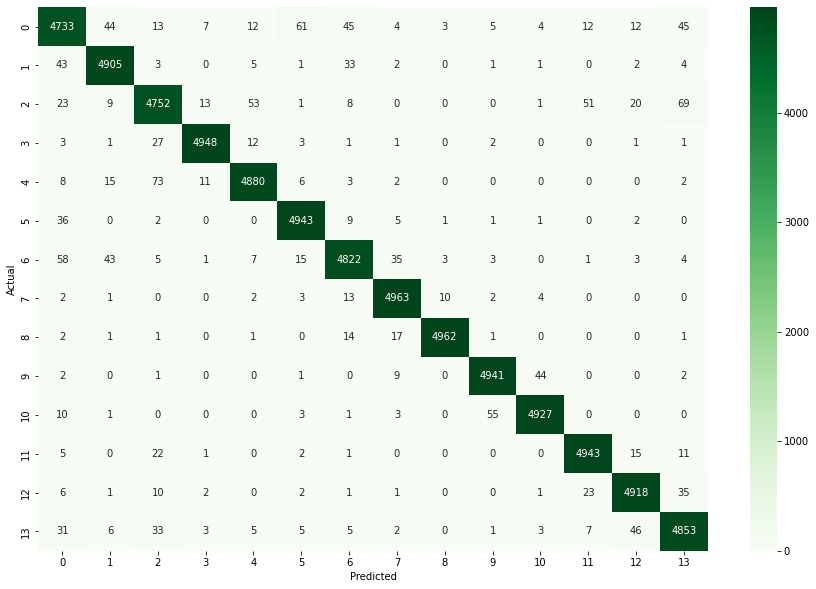

In [21]:
plot_the_confusion_matrix(testing_y, predicted_y)

In [22]:
print_the_classification_report(testing_y, predicted_y)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5000
           1       0.98      0.98      0.98      5000
           2       0.96      0.95      0.96      5000
           3       0.99      0.99      0.99      5000
           4       0.98      0.98      0.98      5000
           5       0.98      0.99      0.98      5000
           6       0.97      0.96      0.97      5000
           7       0.98      0.99      0.99      5000
           8       1.00      0.99      0.99      5000
           9       0.99      0.99      0.99      5000
          10       0.99      0.99      0.99      5000
          11       0.98      0.99      0.98      5000
          12       0.98      0.98      0.98      5000
          13       0.97      0.97      0.97      5000

    accuracy                           0.98     70000
   macro avg       0.98      0.98      0.98     70000
weighted avg       0.98      0.98      0.98     70000



Now that we have a model with higher accurecy, we should save it and release a new version of our web app to the server.

In [23]:
joblib.dump(SGDClassifier_pipeline, os.getcwd() + r"\best_Pipeline.pkl")

['C:\\Users\\Behzad\\Desktop\\Git-Projects\\Machine-Learning - master\\Risk Alive Case Study - Copy\\best_Pipeline.pkl']

As explained in step 1, in order to release a new version, we should:


1. Freeze our requirements using `pip3 freeze > requirements.txt` to update our requirements list
2. `git add` and `git commit` all the files that need to be included in the new release ("best_pipeline.pkl" in this case)
3. Push updated repository to the Heroku using `git push heroku master`

After releasing the new version, the server will restart the app with new model. Finally, We can visit the new version of our web app at:  
[Flask Text Classifier App](https://flasktextclassifierapp.herokuapp.com/)